### Structure 
* hypterparameters
* Define replay buffer
* Define Gaussian noise
* Define neural network
    * Define value network
    * Define policy network
* Define RL framework
* Define training loop
    * select action, get feedback
    * store experience
    * learn using a minibatch

### Environment for Demo
https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

In [1]:
import random
import math
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

from IPython.display import clear_output
import matplotlib.pyplot as plt

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hypterparameters
BATCH_SIZE = 128
HIDDEN_DIM = 256  # dimention of the hidden layer
MAX_EPISODE = 10000    # total number of episodes
RENDER = True     # whether to render the environment or not
MAX_STEP = 500

## Gaussian Noise
https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/gaussian_strategy.py

In [2]:
class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1.0, min_sigma=1.0, decay_period=1000000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def choose_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(size=len(action)) * sigma
        return np.clip(action, self.low, self.high)

In [3]:
def plot(time_count, rewards):
    clear_output(True)
    plt.figure(figsize=(16,9))
    plt.title('time count %s. reward: %s' % (time_count, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [4]:
# Define the replay buffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.replay_buffer = []
        self.position = 0
    
    def store(self, state, action, reward, next_state, done):
        """Saves a transition experience."""
        if len(self.replay_buffer) < self.capacity:
            self.replay_buffer.append(None)
        self.replay_buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.replay_buffer)

# Define neural networks
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super().__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super().__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Define TD3 framework
class TD3(object):
    def __init__(self, env,
                policy_lr=3e-4,
                value_lr=3e-4,
                replay_buffer_size=1000000):
        self.learn_step_counter = 0     # counter to delay policy update
        
        self.state_dim  = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.hidden_dim = HIDDEN_DIM

        self.value_net1  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.value_net2  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        self.target_value_net1  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.target_value_net2  = ValueNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.target_policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        
        self.target_value_net1.load_state_dict(self.value_net1.state_dict())
        self.target_value_net2.load_state_dict(self.value_net2.state_dict())
        self.target_policy_net.load_state_dict(self.target_policy_net.state_dict())   

        self.value_optimizer1  = torch.optim.Adam(self.value_net1.parameters(),  lr=value_lr)
        self.value_optimizer2  = torch.optim.Adam(self.value_net2.parameters(),  lr=value_lr)
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)

        self.value_loss_func = nn.MSELoss()

        self.replay_buffer = ReplayBuffer(replay_buffer_size)
    
    def choose_action(self, state):
        """select an action based on the current observation"""
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.policy_net(state)
        return action.detach().cpu().numpy()[0]
    
    def learn(self, 
            gamma=0.99,
            soft_tau=0.005,
            noise_std=0.2,
            noise_clip=0.5,
            policy_update=2):
        """update actor and critic network"""
        if len(self.replay_buffer) < BATCH_SIZE:
            return
    
        state, action, reward, next_state, done = self.replay_buffer.sample(BATCH_SIZE)

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
        
        # target policy smoothing
        next_action    = self.target_policy_net(next_state)
        noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
        noise = torch.clamp(noise, -noise_clip, noise_clip)
        next_action += noise
        
        # clipped double-Q learning
        target_value1  = self.target_value_net1(next_state, next_action)
        target_value2  = self.target_value_net2(next_state, next_action)
        target_value = torch.min(target_value1, target_value2)
        expected_value = reward + (1.0 - done) * gamma * target_value

        value1 = self.value_net1(state, action)
        value2 = self.value_net2(state, action)
        value_loss1 = self.value_loss_func(value1, expected_value.detach())
        value_loss2 = self.value_loss_func(value2, expected_value.detach())     

        self.value_optimizer1.zero_grad()
        value_loss1.backward()
        self.value_optimizer1.step()
        
        self.value_optimizer2.zero_grad()
        value_loss2.backward()
        self.value_optimizer2.step()
        
        # delayed policy updates
        if self.learn_step_counter % policy_update == 0:
            policy_loss = self.value_net1(state, self.policy_net(state))
            policy_loss = -policy_loss.mean()
            
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()
            
            # update target net
            self.soft_update(self.value_net1, self.target_value_net1, soft_tau=soft_tau)
            self.soft_update(self.value_net2, self.target_value_net2, soft_tau=soft_tau)
            self.soft_update(self.policy_net, self.target_policy_net, soft_tau=soft_tau)
            
        self.learn_step_counter += 1
        
    def soft_update(self, net, target_net, soft_tau=1e-2):
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)
            
    def save(self, filename):
        torch.save(self.value_net1.state_dict(), filename + "_value1")
        torch.save(self.value_optimizer1.state_dict(), filename + "_value_optimizer1")
        torch.save(self.value_net2.state_dict(), filename + "_value2")
        torch.save(self.value_optimizer2.state_dict(), filename + "_value_optimizer2")

        torch.save(self.policy.state_dict(), filename + "_policy")
        torch.save(self.policy_optimizer.state_dict(), filename + "_policy_optimizer")

    def load(self, filename):
        self.value_net1.load_state_dict(torch.load(filename + "_value1"))
        self.value_optimizer1.load_state_dict(torch.load(filename + "_value_optimizer1"))
        self.target_value_net1 = copy.deepcopy(self.value)
        
        self.value_net2.load_state_dict(torch.load(filename + "_value2"))
        self.value_optimizer2.load_state_dict(torch.load(filename + "_value_optimizer2"))
        self.target_value_net2 = copy.deepcopy(self.value)

        self.policy_net.load_state_dict(torch.load(filename + "_policy"))
        self.policy_optimizer.load_state_dict(torch.load(filename + "_policy_optimizer"))
        self.target_policy_net = copy.deepcopy(self.policy) 

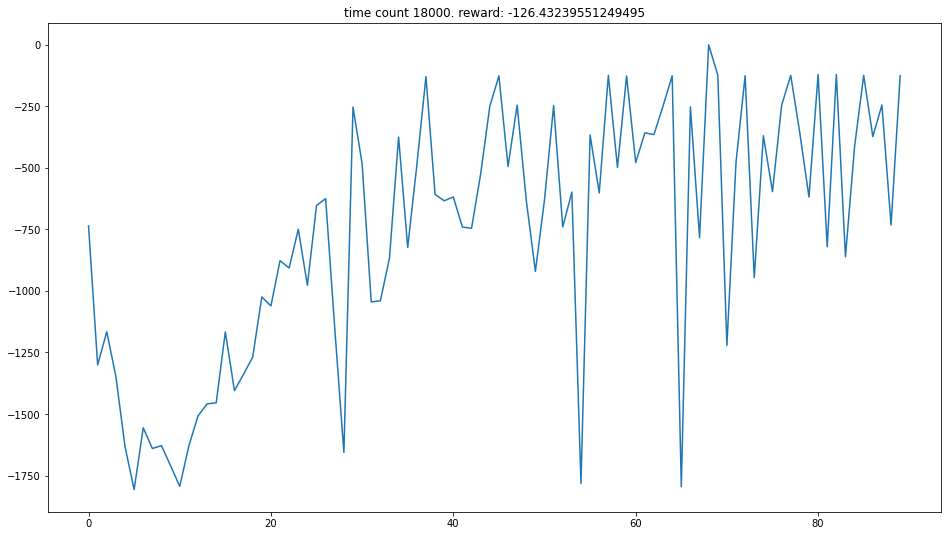

KeyboardInterrupt: 

In [5]:
# training loop
env = gym.make("Pendulum-v0")
noise = GaussianExploration(env.action_space)
rl = TD3(env) # initiate the RL framework

rewards = []
time_count = 1

for i_episode in range(MAX_EPISODE):
    s = env.reset()
    episode_reward = 0
    
    # while True:
    for step in range(MAX_STEP):  
        if RENDER:
            env.render()    # show environment
            
        a = rl.choose_action(s)
        a = noise.choose_action(a, step)

        # select action and get feedback
        s_, r, done, info = env.step(a)

        # store transition experience into replay buffer
        rl.replay_buffer.store(s, a, r, s_, done)
        
        # learning
        rl.learn()
        
        if time_count % 1000 == 0:
            plot(time_count, rewards)
        
        # episode terminates, enter next episode
        if done: 
            break

        s = s_
        time_count += 1
        episode_reward += r
    
    rewards.append(episode_reward)
#     if i_episode % 50 == 0:
#          print("Episode finished after {} timesteps".format(time_count+1))
        
env.close()

In [11]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env_name, seed, eval_episodes=10):
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.choose_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

eval_policy(rl, "Pendulum-v0", 1)

---------------------------------------
Evaluation over 10 episodes: -270.152
---------------------------------------


-270.1523969713559